In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import pickle
import matplotlib.pyplot as plt
from my_functions import load_data, preprocess_data, plotting_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [15]:
data_path = 'data/churn_train_data.pcl'
df = preprocess_data(load_data(data_path))

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

distribution = lambda s: {k: float(f'{v:.4f}') for k, v in s.value_counts(normalize=True).to_dict().items()}
print(f"Train target class distribution: {distribution(y_train)}")
print(f"Test target class distribution: {distribution(y_test)}")



Train target class distribution: {0.0: 0.9361, 1.0: 0.0639}
Test target class distribution: {0.0: 0.9361, 1.0: 0.0639}


In [3]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)


In [4]:

# 3. Fit Isolation Forest on majority class in TRAIN set
majority_class_train = X_train_scaled[y_train == 0]
iso = IsolationForest(n_estimators=200, contamination=0.20, random_state=42)
iso.fit(majority_class_train)

# 4. Get anomaly scores and predictions for TEST set only
test_scores = iso.decision_function(X_test_scaled)
test_scores

array([ 0.05012085,  0.04314889,  0.04375918, ...,  0.0276611 ,
        0.01416316, -0.10417398])

In [5]:
y_pred_default = iso.predict(X_test_scaled)
y_pred_default = np.where(y_pred_default == -1, 1, 0)

print("\nDefault threshold evaluation:")
print(classification_report(y_test, y_pred_default, digits=4))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_default))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_default):.4f}")



Default threshold evaluation:
              precision    recall  f1-score   support

         0.0     0.9676    0.7990    0.8752     28083
         1.0     0.1711    0.6077    0.2670      1917

    accuracy                         0.7868     30000
   macro avg     0.5693    0.7034    0.5711     30000
weighted avg     0.9167    0.7868    0.8364     30000

Confusion matrix:
[[22438  5645]
 [  752  1165]]
ROC AUC: 0.7034


In [6]:
# 5. Threshold tuning using anomaly scores
prec, rec, thresh = precision_recall_curve(y_test, -test_scores)
f1 = 2 * prec * rec / (prec + rec + 1e-8)
best_idx = f1.argmax()
best_threshold = thresh[best_idx]
print(f"\nBest threshold: {best_threshold:.4f}, Best F1: {f1[best_idx]:.4f}")

# Apply best threshold to test scores
y_pred_best = (-test_scores > best_threshold).astype(int)
print("\nBest F1 threshold evaluation:")
print(classification_report(y_test, y_pred_best, digits=4))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_best))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_best):.4f}")



Best threshold: 0.0226, Best F1: 0.2990

Best F1 threshold evaluation:
              precision    recall  f1-score   support

         0.0     0.9549    0.9291    0.9418     28083
         1.0     0.2562    0.3579    0.2986      1917

    accuracy                         0.8926     30000
   macro avg     0.6056    0.6435    0.6202     30000
weighted avg     0.9103    0.8926    0.9007     30000

Confusion matrix:
[[26091  1992]
 [ 1231   686]]
ROC AUC: 0.6435


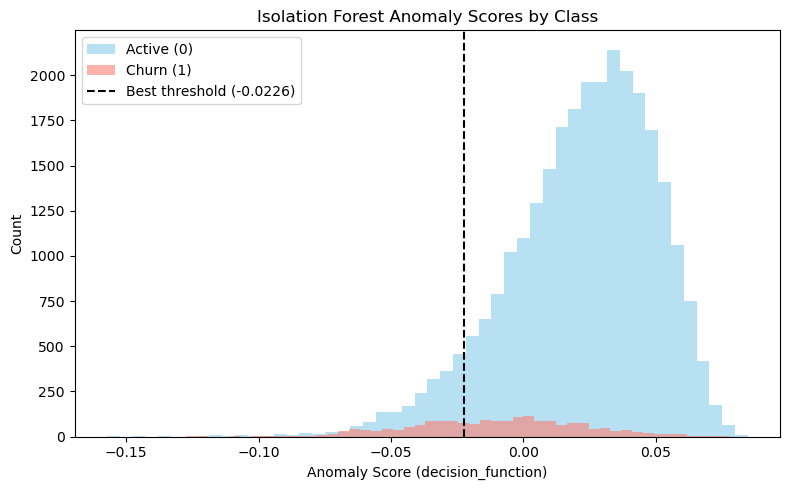

In [9]:


# Visualization: Anomaly score distribution
plt.figure(figsize=(8,5))
plt.hist(test_scores[y_test == 0], bins=50, alpha=0.6, label='Active (0)', color='skyblue')
plt.hist(test_scores[y_test == 1], bins=50, alpha=0.6, label='Churn (1)', color='salmon')
plt.axvline(x=-best_threshold, color='black', linestyle='--', label=f'Best threshold ({-best_threshold:.4f})')
plt.xlabel('Anomaly Score (decision_function)')
plt.ylabel('Count')
plt.title('Isolation Forest Anomaly Scores by Class')
plt.legend()
plt.tight_layout()
plt.show()


Analysis of the iso_score Distribution

Both classes (Non-churn and Churn) occupy almost identical value ranges of iso_score.

    - Churners (1) do not have a distinct cluster at lower or higher values—their distribution almost fully overlaps with the majority (Non-churn, 0).

    - The Churn (brown) histogram is just a tiny shadow under the much larger Non-churn curve; there’s no visible region where churners dominate.

What This Means:
iso_score contains almost zero signal to differentiate churners from non-churners.
